--- Advanced A* Pathfinding Solver Initialized ---
Grid Size: 10x10
Start Position: (0, 0) | End Position: (8, 9)

SUCCESS! Path found with 17 steps (including start/end).
Path Coordinates:
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9)]


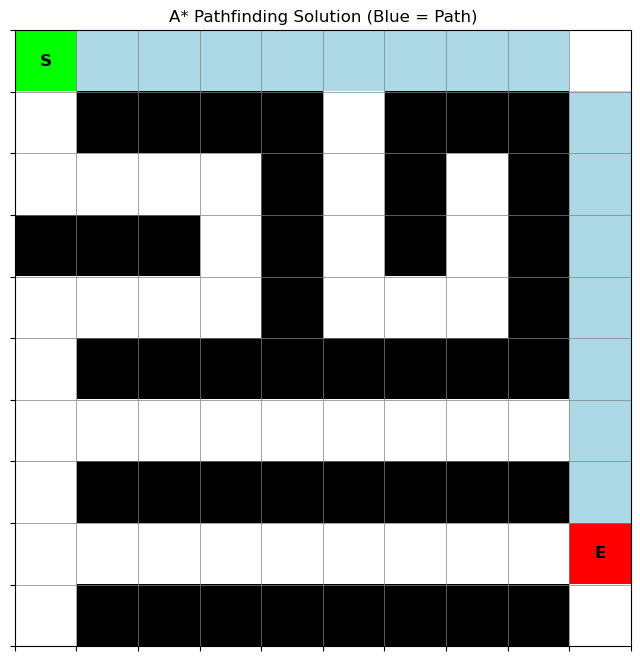

In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

# --- Node Class ---

class Node:
    """
    Represents a single point (cell) on the grid for A* search.
    """
    def __init__(self, position: tuple, parent=None):
        self.position = position  # (row, col)
        self.parent = parent
        
        # G-score: Cost from the start node to the current node
        self.g = float('inf')
        # H-score: Heuristic cost (estimated cost) from the current node to the end node
        self.h = float('inf')
        # F-score: Total estimated cost (F = G + H)
        self.f = float('inf')

    def __lt__(self, other):
        """
        Comparison function for the priority queue (heapq). 
        A\* prioritizes the node with the lowest F-score.
        """
        return self.f < other.f

    def __eq__(self, other):
        """
        Equality check based on position, useful for set operations.
        """
        return self.position == other.position

    def __hash__(self):
        """
        Hash function based on position, necessary for using Node in sets/dictionaries.
        """
        return hash(self.position)

# --- A* Algorithm Implementation ---

def astar_search(grid: np.ndarray, start_pos: tuple, end_pos: tuple) -> list:
    """
    Finds the shortest path from start_pos to end_pos on the grid using the A* algorithm.
    
    Args:
        grid: A 2D numpy array representing the map. 0=open, 1=obstacle.
        start_pos: The starting (row, col) tuple.
        end_pos: The destination (row, col) tuple.
        
    Returns:
        A list of (row, col) tuples representing the optimal path, or an empty list if no path exists.
    """
    
    rows, cols = grid.shape
    
    # 1. Initialize start and end nodes
    start_node = Node(start_pos)
    start_node.g = 0
    start_node.h = 0
    start_node.f = 0
    
    end_node = Node(end_pos)
    
    # 2. Setup the frontier (open list) and visited set (closed list)
    # The open list is a min-heap (priority queue) ordered by F-score
    open_list = []
    heapq.heappush(open_list, start_node)
    
    # Track all visited nodes and their current best G-scores
    g_scores = {start_node.position: 0}
    
    # Helper for valid movement directions (8 directions: straight + diagonal)
    # (dr, dc): change in row, change in column
    movements = [
        (0, 1), (0, -1), (1, 0), (-1, 0),    # Straight moves (Cost: 10)
        (1, 1), (1, -1), (-1, 1), (-1, -1)  # Diagonal moves (Cost: 14, approx sqrt(2)*10)
    ]
    # Corresponding costs (using 10/14 for integer arithmetic, which is common)
    costs = [10, 10, 10, 10, 14, 14, 14, 14]
    
    # 3. Main A* loop
    while open_list:
        # Get the node with the lowest F-score (min-heap property)
        current_node = heapq.heappop(open_list)
        
        # Check if we reached the goal
        if current_node.position == end_node.position:
            # Reconstruct and return the path
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1] # Reverse the path to go from start to end

        # Explore neighbors
        for i, (dr, dc) in enumerate(movements):
            neighbor_pos = (current_node.position[0] + dr, current_node.position[1] + dc)
            move_cost = costs[i] / 10.0 # Normalize back to 1.0 (straight) or 1.4 (diagonal)
            
            # Check bounds
            if not (0 <= neighbor_pos[0] < rows and 0 <= neighbor_pos[1] < cols):
                continue

            # Check for obstacle (grid value 1)
            if grid[neighbor_pos] == 1:
                continue
            
            # Calculate tentative G-score
            tentative_g_score = current_node.g + move_cost
            
            # If a better path to this neighbor is found
            if tentative_g_score < g_scores.get(neighbor_pos, float('inf')):
                
                # Create or update the neighbor node
                neighbor_node = Node(neighbor_pos, current_node)
                neighbor_node.g = tentative_g_score
                
                # Heuristic: Manhattan distance is a good choice for grid-based movement
                # h = distance between neighbor and end node
                h_score = abs(neighbor_pos[0] - end_pos[0]) + abs(neighbor_pos[1] - end_pos[1])
                neighbor_node.h = h_score
                
                # Calculate F-score
                neighbor_node.f = neighbor_node.g + neighbor_node.h
                
                # Update records and add to the open list
                g_scores[neighbor_pos] = tentative_g_score
                heapq.heappush(open_list, neighbor_node)

    # If the open list is empty and we haven't reached the goal, no path exists
    return []

# --- Visualization and Execution ---

def visualize_path(grid: np.ndarray, path: list, start_pos: tuple, end_pos: tuple):
    """
    Plots the grid, obstacles, and the found path using matplotlib.
    """
    plt.figure(figsize=(8, 8))
    
    # Create an image representing the grid: 0=open (white), 1=obstacle (black)
    grid_display = grid.copy()
    
    # Mark the path
    for r, c in path:
        grid_display[r, c] = 2  # Use 2 for path (will be colored later)
        
    # Mark start and end points
    grid_display[start_pos] = 3 # Use 3 for start (green)
    grid_display[end_pos] = 4   # Use 4 for end (red)

    # Define the color map: 0=White (open), 1=Black (obstacle), 2=Blue (path), 3=Green (start), 4=Red (end)
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'lightblue', 'lime', 'red'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(grid_display, cmap=cmap, norm=norm, origin='upper')
    
    # Add grid lines
    plt.grid(True, which='both', color='gray', linewidth=0.5)
    plt.xticks(np.arange(-0.5, grid.shape[1], 1), [])
    plt.yticks(np.arange(-0.5, grid.shape[0], 1), [])
    
    plt.title('A* Pathfinding Solution (Blue = Path)')
    plt.text(start_pos[1], start_pos[0], 'S', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
    plt.text(end_pos[1], end_pos[0], 'E', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
    plt.show()

def main():
    """
    Sets up the grid, runs A*, and visualizes the result.
    """
    # Define a 10x10 grid: 0 = walkable, 1 = obstacle
    # This matrix defines the complexity of the pathfinding problem
    grid_data = [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
    ]
    grid = np.array(grid_data)
    
    # Define start (S) and end (E) positions (row, col)
    start = (0, 0)
    end = (8, 9)
    
    print("--- Advanced A* Pathfinding Solver Initialized ---")
    print(f"Grid Size: {grid.shape[0]}x{grid.shape[1]}")
    print(f"Start Position: {start} | End Position: {end}")
    
    # Execute the A* search
    path = astar_search(grid, start, end)
    
    if path:
        print(f"\nSUCCESS! Path found with {len(path)} steps (including start/end).")
        print("Path Coordinates:")
        print(path)
        visualize_path(grid, path, start, end)
    else:
        print("\nFAILURE! No path could be found to the destination.")
        
if __name__ == "__main__":
    try:
        main()
    except ImportError:
        print("Error: Required libraries (numpy, matplotlib) are not installed.")
        print("Please install them using: pip install numpy matplotlib")
